In [0]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
filerdd = sc.textFile("dbfs:/FileStore/tables/Auto_Theft_Open_Data.csv")

In [0]:
no_headers = filerdd.zipWithIndex().filter(lambda x: x[1] > 0).map(lambda x: x[0])
splitting = no_headers.map(lambda x: x.split(","))

In [0]:
def select_columns(element):
    # Example: Keep only the first and third columns
    return (element[len(element) - 2], element[len(element) - 1], element[len(element) - 5],element[5],element[16],element[17])

In [0]:
subset_cols = splitting.map(select_columns)
valid_entry = subset_cols.filter(lambda x: float(x[0]) != 0 and float(x[1]) != 0)
rdd_with_index = valid_entry.zipWithIndex()

In [0]:
kmeans = KMeans(n_clusters=50)
coordinates = rdd_with_index.map(lambda x: (x[0][0],x[0][1]))
clusters = kmeans.fit_predict(coordinates.collect())
clusters_b = sc.broadcast(clusters)

In [0]:
print(clusters_b.value[0])

24


In [0]:
def add_clusters(row):
    return row + (clusters_b.value[row[-1]],)

In [0]:
rdd_with_clusters = rdd_with_index.map(add_clusters)

clusters_rdd = sc.parallelize(clusters)

cluster_individual = clusters_rdd.map(lambda x: (x,1))

cluster_counts = cluster_individual.reduceByKey(lambda x,y: x+y)

line_count = rdd_with_clusters.count()

cluster_prob = cluster_counts.map(lambda x: (x[0],x[1]/line_count))

In [0]:
centroids = kmeans.cluster_centers_

scaling_factor = 100
cluster_prob_scaled = cluster_prob.map(lambda x: [x[0],x[1]*scaling_factor])

centroid_sizes = cluster_prob_scaled.map(lambda x: x[1]*scaling_factor)

In [0]:
lng = centroids[:,0]
lat = centroids[:,1]

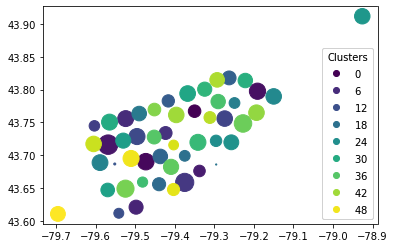

In [0]:
scatter = plt.scatter(lng,lat,s=centroid_sizes.collect(),c=range(centroid_sizes.count()),cmap='viridis')

legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

plt.show()